In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
# from plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
from collections import Counter

In [2]:
import gdown 
url = 'https://drive.google.com/uc?id=1bDLwb_Vq7q2W9S89JB96PgmZG3LsLns9' 
output = 'train_data.csv' # https://drive.google.com/file/d/1bDLwb_Vq7q2W9S89JB96PgmZG3LsLns9/view?usp=sharing 
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1bDLwb_Vq7q2W9S89JB96PgmZG3LsLns9
To: /content/train_data.csv
201MB [00:01, 143MB/s] 


'train_data.csv'

In [3]:
import gdown 
url = 'https://drive.google.com/uc?id=1tsD0PCPB1qvwZnaxFxDGiEw0xKlSEFaP'
output= "resources.csv"
gdown.download(url,output,quiet= False )

# https://drive.google.com/file/d//view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1tsD0PCPB1qvwZnaxFxDGiEw0xKlSEFaP
To: /content/resources.csv
127MB [00:01, 104MB/s] 


'resources.csv'

In [4]:
dft = pd.read_csv('train_data.csv',nrows=60000)
dfr = pd.read_csv('resources.csv')
print(dft.shape)
print(dfr.shape)

(60000, 17)
(1541272, 4)


In [5]:
print("Number of data points in train data", dft.shape)
print('-'*50)
print("The attributes of data :", dft.columns.values)

Number of data points in train data (60000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [6]:
print("Number of data points in train data", dfr.shape)
print(dfr.columns.values)
dfr.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [7]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(dft.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
dft['Date'] = pd.to_datetime(dft['project_submitted_datetime'])
dft.drop('project_submitted_datetime', axis=1, inplace=True)
dft.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
dft = dft[cols]


dft.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1
51140,74477,p189804,4a97f3a390bfe21b99cf5e2b81981c73,Mrs.,CA,2016-04-27 00:46:53,Grades PreK-2,Literacy & Language,Literacy,Mobile Learning with a Mobile Listening Center,Having a class of 24 students comes with diver...,I have a class of twenty-four kindergarten stu...,By having a mobile listening and storage cente...,A mobile listening center will help keep equip...,My students need a mobile listening center to ...,10,1


## 1.1 Text Preprocessing

In [0]:
# merge two column text dataframe: 
dft["essay"] = dft["project_essay_1"].map(str) +\
                        dft["project_essay_2"].map(str) + \
                        dft["project_essay_3"].map(str) + \
                        dft["project_essay_4"].map(str)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
# specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
# general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [0]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
catogories = list(dft['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','')
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_')
    cat_list.append(temp.strip())
    
dft['clean_categories'] = cat_list
dft.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in dft['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [0]:
sub_catogories = list(dft['project_subject_subcategories'].values)

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','')
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

dft['clean_subcategories'] = sub_cat_list
dft.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: 
#https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in dft['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [0]:
d= list(dft['project_grade_category'].values)
grade_cat_list = []
for i in d:
    for j in i.split(' '): 
        j=j.replace('Grades','')
    grade_cat_list.append(j.strip())
    
dft['clean_grade'] = grade_cat_list
dft.drop(['project_grade_category'], axis=1, inplace=True)

my_counter = Counter()
for word in dft['clean_grade'].values:
     my_counter.update(word.split())
project_grade_category_dict= dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))

## 2.1 Prepare the Data Metrix



1.   Spliting the data metrix into train,Cross validate data and test data. 
2.   the Distribution of the data points is 70% in train and 30% in test  



In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dft, dft['project_is_approved'],stratify = dft['project_is_approved'], test_size=0.33)
X_train,X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [15]:
print(y_train.value_counts())
print(y_test.value_counts())
print(y_cv.value_counts())

1    22830
0     4104
Name: project_is_approved, dtype: int64
1    16782
0     3018
Name: project_is_approved, dtype: int64
1    11244
0     2022
Name: project_is_approved, dtype: int64


In [0]:
X_train.drop(["project_is_approved"], axis = 1, inplace = True)
X_test.drop(["project_is_approved"], axis = 1, inplace = True)
X_cv.drop(["project_is_approved"], axis = 1, inplace = True)

In [17]:
from tqdm import tqdm
preprocessed_essays_train = []
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_train.append(sent.lower().strip())


100%|██████████| 26934/26934 [00:14<00:00, 1836.12it/s]


In [18]:
from tqdm import tqdm
preprocessed_essays_test = []
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_test.append(sent.lower().strip())

100%|██████████| 19800/19800 [00:10<00:00, 1833.22it/s]


In [19]:
from tqdm import tqdm
preprocessed_essays_cv = []
for sentance in tqdm(X_cv['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_cv.append(sent.lower().strip())


100%|██████████| 13266/13266 [00:07<00:00, 1830.71it/s]


In [20]:
from tqdm import tqdm
preprocessed_titles_cv = []
for sentance in tqdm(X_cv['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_cv.append(sent.lower().strip())

100%|██████████| 13266/13266 [00:00<00:00, 39504.18it/s]


In [21]:
from tqdm import tqdm
preprocessed_titles_train = []
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_train.append(sent.lower().strip())


100%|██████████| 26934/26934 [00:00<00:00, 40669.69it/s]


In [22]:
from tqdm import tqdm
preprocessed_titles_test = []
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_test.append(sent.lower().strip())

100%|██████████| 19800/19800 [00:00<00:00, 40080.38it/s]


##  Encoding numerical, Categorical features

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False,binary=True)
vectorizer1.fit(X_train['clean_categories'].values)
X_train_cat = vectorizer1.transform(X_train['clean_categories'].values)
X_cv_cat = vectorizer1.transform(X_cv['clean_categories'].values)
X_test_cat = vectorizer1.transform(X_test['clean_categories'].values)
print(vectorizer1.get_feature_names())


['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']


In [24]:
f1=vectorizer1.get_feature_names()
print("After vectorizations")
print(X_train_cat.shape, y_train.shape)
print(X_cv_cat.shape, y_cv.shape)
print(X_test_cat.shape, y_test.shape)
print("="*100)


After vectorizations
(26934, 9) (26934,)
(13266, 9) (13266,)
(19800, 9) (19800,)


In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer2 = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer2.fit(X_train['clean_subcategories'].values)
X_train_subcat = vectorizer2.transform(X_train['clean_subcategories'].values)
X_cv_subcat = vectorizer2.transform(X_cv['clean_subcategories'].values)
X_test_subcat = vectorizer2.transform(X_test['clean_subcategories'].values)
print(vectorizer2.get_feature_names())

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'History_Geography', 'Music', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']


In [26]:
print("After vectorizations")
print(X_train_subcat.shape, y_train.shape)
print(X_cv_subcat.shape, y_cv.shape)
print(X_test_subcat.shape, y_test.shape)
print("="*100)

After vectorizations
(26934, 30) (26934,)
(13266, 30) (13266,)
(19800, 30) (19800,)


In [27]:
from collections import Counter
my_counter = Counter()
for word in dft['school_state'].values:
    my_counter.update(word.split())
school_state_dict = dict(my_counter)
sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))
print(sorted_school_state_dict)

{'VT': 40, 'WY': 58, 'ND': 78, 'MT': 120, 'RI': 148, 'NH': 175, 'NE': 176, 'SD': 177, 'DE': 181, 'AK': 188, 'WV': 252, 'HI': 270, 'ME': 277, 'DC': 294, 'NM': 295, 'KS': 340, 'IA': 363, 'ID': 371, 'AR': 534, 'CO': 638, 'MN': 671, 'OR': 676, 'MS': 710, 'KY': 725, 'NV': 774, 'MD': 801, 'CT': 923, 'TN': 935, 'AL': 944, 'UT': 958, 'WI': 994, 'VA': 1124, 'AZ': 1172, 'NJ': 1235, 'OK': 1283, 'LA': 1308, 'WA': 1309, 'MA': 1312, 'OH': 1399, 'MO': 1421, 'IN': 1431, 'PA': 1699, 'MI': 1760, 'SC': 2186, 'GA': 2203, 'IL': 2371, 'NC': 2831, 'FL': 3444, 'TX': 4010, 'NY': 4039, 'CA': 8377}


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer3 = CountVectorizer(vocabulary=list(sorted_school_state_dict.keys()), lowercase=False, binary=True)
vectorizer3.fit(dft['school_state'].values)
X_train_school_state = vectorizer3.transform(X_train['school_state'].values)
X_cv_school_state = vectorizer3.transform(X_cv['school_state'].values)
X_test_school_state = vectorizer3.transform(X_test['school_state'].values)
print(vectorizer3.get_feature_names())

['VT', 'WY', 'ND', 'MT', 'RI', 'NH', 'NE', 'SD', 'DE', 'AK', 'WV', 'HI', 'ME', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'MS', 'KY', 'NV', 'MD', 'CT', 'TN', 'AL', 'UT', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'LA', 'WA', 'MA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'TX', 'NY', 'CA']


In [29]:
print("After vectorizations")
print(X_train_school_state .shape, y_train.shape)
print(X_cv_school_state .shape, y_cv.shape)
print(X_test_school_state .shape, y_test.shape)
print("="*100)

After vectorizations
(26934, 51) (26934,)
(13266, 51) (13266,)
(19800, 51) (19800,)


In [30]:
dft['clean_grade']=dft['clean_grade'].fillna("")
from sklearn.feature_extraction.text import CountVectorizer
vectorizer4 = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()),lowercase=False, binary=True)
vectorizer4.fit(dft['clean_grade'].values)
X_train_project_grade_category = vectorizer4.transform(X_train['clean_grade'].values)
X_cv_project_grade_category = vectorizer4.transform(X_cv['clean_grade'].values)
X_test_project_grade_category = vectorizer4.transform(X_test['clean_grade'].values)
print(vectorizer4.get_feature_names())

['9-12', '6-8', '3-5', 'PreK-2']


In [31]:
print("After vectorizations")
print(X_train_project_grade_category .shape, y_train.shape)
print(X_cv_project_grade_category .shape, y_cv.shape)
print(X_test_project_grade_category .shape, y_test.shape)
print("="*100)

After vectorizations
(26934, 4) (26934,)
(13266, 4) (13266,)
(19800, 4) (19800,)


In [0]:
dft['teacher_prefix']=dft['teacher_prefix'].fillna(" ")
my_counter = Counter()
for word in dft['teacher_prefix'].values:
    my_counter.update(word.split())
teacher_cat_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_cat_dict.items(), key=lambda kv: kv[1]))

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer5 = CountVectorizer(vocabulary=list(sorted_teacher_prefix_dict.keys()), lowercase=False,binary=True)
vectorizer5.fit(dft['teacher_prefix'].values.astype('U'))
X_train_teacher_prefix = vectorizer5.transform(X_train['teacher_prefix'].values.astype('U'))
X_cv_teacher_prefix= vectorizer5.transform(X_cv['teacher_prefix'].values.astype('U'))
X_test_teacher_prefix = vectorizer5.transform(X_test['teacher_prefix'].values.astype('U'))
print(vectorizer5.get_feature_names())

['Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']


In [34]:
print("After vectorizations")
print(X_train_teacher_prefix .shape, y_train.shape)
print(X_cv_teacher_prefix .shape, y_cv.shape)
print(X_test_teacher_prefix .shape, y_test.shape)
print("="*100)

After vectorizations
(26934, 5) (26934,)
(13266, 5) (13266,)
(19800, 5) (19800,)


### Encoding Preprocessed Essay and Project_title using one hot encoding 

In [0]:
X_train_essay=preprocessed_essays_train
X_cv_essay=preprocessed_essays_cv
X_test_essay=preprocessed_essays_test

X_train_title=preprocessed_titles_train
X_cv_title=preprocessed_titles_cv
X_test_title=preprocessed_titles_test
vectorizer6 = CountVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer6.fit(X_train_essay)

X_train_bow = vectorizer6.transform(X_train_essay)
X_cv_bow = vectorizer6.transform(X_cv_essay)
X_test_bow = vectorizer6.transform(X_test_essay)


In [36]:
#bow featurization title
vectorizer7 = CountVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer7.fit(X_train_title)# that is learned from trainned data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow_title = vectorizer7.transform(X_train_title)
X_cv_bow_title= vectorizer7.transform(X_cv_title)
X_test_bow_title = vectorizer7.transform(X_test_title)
print("After vectorizations")
print(X_train_bow_title.shape, y_train.shape)
print(X_cv_bow_title.shape, y_cv.shape)
print(X_test_bow_title.shape, y_test.shape)
print("="*100)


After vectorizations
(26934, 1896) (26934,)
(13266, 1896) (13266,)
(19800, 1896) (19800,)


In [37]:
#for titles
from sklearn.feature_extraction.text import TfidfVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer8 = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer8.fit(X_train_title)# that is learned from trained data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_title = vectorizer8.transform(X_train_title)
X_cv_tf_title= vectorizer8.transform(X_cv_title)
X_test_tf_title = vectorizer8.transform(X_test_title)
print("After vectorizations")
print(X_train_tf_title.shape, y_train.shape)
print(X_cv_tf_title.shape, y_cv.shape)
print(X_test_tf_title.shape, y_test.shape)
print("="*100)


After vectorizations
(26934, 1896) (26934,)
(13266, 1896) (13266,)
(19800, 1896) (19800,)


In [38]:
#for essay
from sklearn.feature_extraction.text import TfidfVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer9 = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer9.fit(X_train_essay)# that is learned from trained data
# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_essay = vectorizer9.transform(X_train_essay)
X_cv_tf_essay= vectorizer9.transform(X_cv_essay)
X_test_tf_essay = vectorizer9.transform(X_test_essay)
print("After vectorizations")
print(X_train_tf_essay.shape, y_train.shape)
print(X_cv_tf_essay.shape, y_cv.shape)
print(X_test_tf_essay.shape, y_test.shape)
print("="*100)

After vectorizations
(26934, 5000) (26934,)
(13266, 5000) (13266,)
(19800, 5000) (19800,)


In [39]:
import gdown 
url = 'https://drive.google.com/uc?id=1MqUasf7jYoPbG35MJ28VQcOjjNp-ZDDp' 
output = 'gloveFile' 
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1MqUasf7jYoPbG35MJ28VQcOjjNp-ZDDp
To: /content/gloveFile
128MB [00:00, 166MB/s] 


'gloveFile'

In [0]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039

def loadGloveModel(gloveFile):
    
    print ("Loading Glove Model")
    
    f = open(gloveFile,'r', encoding = 'utf8')
    
    model = {}
    
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    
    print ("Done.",len(model)," words loaded!")
    
    return model


In [0]:
import pickle 
with open('gloveFile', 'rb') as f:
  model = pickle.load(f)
  glove_words =  set(model.keys())


In [0]:
def func(wordlist):
    
  train_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(wordlist): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length # we are taking the 300dimensions very large
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_avg_w2v_vectors.append(vector)
    
  print(len(train_avg_w2v_vectors))
  print(len(train_avg_w2v_vectors[0]))
  return train_avg_w2v_vectors

In [43]:
train_avg_w2v_vectors=func(preprocessed_essays_train)
test_avg_w2v_vectors=func(preprocessed_essays_test)
cv_avg_w2v_vectors=func(preprocessed_essays_cv)
#for titles
cv_avg_w2v_vectors_title=func(preprocessed_titles_cv)
test_avg_w2v_vectors_title=func(preprocessed_titles_test)
train_avg_w2v_vectors_title=func(preprocessed_titles_train)

  1%|▏         | 250/19800 [00:00<00:07, 2488.24it/s]

26934
300


  2%|▏         | 259/13266 [00:00<00:05, 2586.82it/s]

19800
300


 41%|████      | 5400/13266 [00:00<00:00, 53995.42it/s]

13266
300


 28%|██▊       | 5478/19800 [00:00<00:00, 54771.83it/s]

13266
300


 20%|██        | 5436/26934 [00:00<00:00, 54354.87it/s]

19800
300


100%|██████████| 26934/26934 [00:00<00:00, 54379.00it/s]

26934
300


## Using Pretrained Models: TFIDF weighted W2V for Vectorization 

In [0]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
def tf_idf_done(word_list):
    train_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(word_list): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split():#.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
              #vec = model.wv[word]  
              vec = model[word] # getting the vector for each word
# here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        train_title_tfidf_w2v_vectors.append(vector)
    print(len(train_title_tfidf_w2v_vectors))
    print(len(train_title_tfidf_w2v_vectors[0]))
    return train_title_tfidf_w2v_vectors


In [46]:
train_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_train)
test_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_test)
cv_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_cv)


  0%|          | 61/19800 [00:00<00:33, 597.70it/s]

26934
300


  0%|          | 53/13266 [00:00<00:25, 525.95it/s]

19800
300


100%|██████████| 13266/13266 [00:24<00:00, 544.33it/s]

13266
300


In [47]:
train_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_train)
test_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_test)
cv_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_cv)

 22%|██▏       | 4325/19800 [00:00<00:00, 22419.48it/s]

26934
300


 36%|███▌      | 4755/13266 [00:00<00:00, 24760.57it/s]

19800
300


100%|██████████| 13266/13266 [00:00<00:00, 25421.23it/s]

13266
300


##  Vectorizing Numerical Data

In [48]:
price_data = dfr.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
dft = pd.merge(dft, price_data, on='id', how='left')
print(price_data.head(2))
# we also have to do this in tran,test and cv
# so also merge the resource data with the trian,cv and test
X_train = pd.merge(X_train, price_data, on = "id", how = "left")
#print(x_train.columns)
X_test = pd.merge(X_test, price_data, on = "id", how = "left")
X_cv = pd.merge(X_cv, price_data, on = "id", how = "left")

        id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21


In [0]:
#standardization
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing


price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1))
train_price_standar = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
test_price_standar = price_scalar.transform(X_test['price'].values.reshape(-1, 1))
cv_price_standar = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))

In [0]:
# previous_year_projects
price_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
train_prev_proj_standar =price_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
test_prev_proj_standar =price_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
cv_prev_proj_standar = price_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))


In [0]:
price_scalar.fit(X_train['quantity'].values.reshape(-1,1))
train_qnty_standar = price_scalar.transform(X_train['quantity'].values.reshape(-1, 1))
cv_qnty_standar = price_scalar.transform(X_cv['quantity'].values.reshape(-1, 1))
test_qnty_standar = price_scalar.transform(X_test['quantity'].values.reshape(-1, 1))

### Merging all the Data Mertix

In [52]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx
X_set1_train = hstack((X_train_bow_title,X_train_bow,# all bows
                       X_train_teacher_prefix,X_train_cat,X_train_subcat
                      ,X_train_project_grade_category,X_train_school_state,
                       train_qnty_standar,train_price_standar,train_prev_proj_standar))
print(X_set1_train.shape, y_train.shape)

(26934, 6998) (26934,)


In [53]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx
X_set1_cv = hstack((X_cv_bow_title,X_cv_bow,
                    X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                    X_cv_project_grade_category,X_cv_school_state,
                    cv_qnty_standar,cv_price_standar,cv_prev_proj_standar))
print(X_set1_cv.shape, y_cv.shape)

(13266, 6998) (13266,)


In [54]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx 
X_set1_test = hstack((X_test_bow_title,X_test_bow,
                      X_test_teacher_prefix,X_test_cat,X_test_subcat,
                      X_test_project_grade_category,X_test_school_state,
                      test_qnty_standar,test_price_standar,test_prev_proj_standar))
print(X_set1_test.shape, y_test.shape)


(19800, 6998) (19800,)


In [55]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :) 

X_set2_train = hstack((X_train_tf_essay,X_train_tf_title,
                       X_train_teacher_prefix,X_train_cat,X_train_subcat,
                       X_train_project_grade_category,X_train_school_state,
                       train_qnty_standar,train_price_standar,train_prev_proj_standar))
print(X_set2_train.shape, y_train.shape)



(26934, 6998) (26934,)


In [56]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set2_cv = hstack((X_cv_tf_essay,X_cv_tf_title,
                    X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                    X_cv_project_grade_category,X_cv_school_state,
                    cv_qnty_standar,cv_price_standar,cv_prev_proj_standar))
print(X_set2_cv.shape, y_cv.shape)

(13266, 6998) (13266,)


In [57]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set2_test = hstack((X_test_tf_essay,X_test_tf_title,
                      X_test_teacher_prefix,X_test_cat,X_test_subcat,
                      X_test_project_grade_category,X_test_school_state,
                      test_qnty_standar,test_price_standar,test_prev_proj_standar)).tocsr()
print(X_set2_test.shape, y_test.shape)


(19800, 6998) (19800,)


In [58]:
from scipy.sparse import hstack
import numpy
X_set3_train = hstack((train_avg_w2v_vectors,train_avg_w2v_vectors_title,train_prev_proj_standar,train_price_standar,train_qnty_standar,
                       X_train_teacher_prefix,X_train_cat,X_train_subcat,
                       X_train_project_grade_category,X_train_school_state))
print(X_set3_train.shape, y_train.shape)

(26934, 702) (26934,)


In [59]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set3_cv =hstack((cv_avg_w2v_vectors,cv_avg_w2v_vectors_title,cv_prev_proj_standar,cv_price_standar,cv_qnty_standar,
                    X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                    X_cv_project_grade_category,X_cv_school_state))
print(X_set3_cv.shape, y_cv.shape)

(13266, 702) (13266,)


In [60]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set3_test =hstack((test_avg_w2v_vectors,test_avg_w2v_vectors_title,test_prev_proj_standar,test_price_standar,
                     test_qnty_standar,
                     X_test_teacher_prefix,X_test_cat,X_test_subcat,
                     X_test_project_grade_category,X_test_school_state))
print(X_set3_test.shape, y_test.shape)

(19800, 702) (19800,)


In [61]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set4_train =hstack((train_tfidf_w2v_vectors, train_title_tfidf_w2v_vectors,train_prev_proj_standar,
                     train_price_standar,train_qnty_standar,
                      X_train_teacher_prefix,X_train_cat,X_train_subcat,
                      X_train_project_grade_category,X_train_school_state))

print(X_set4_train.shape, y_train.shape)

(26934, 702) (26934,)


In [62]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set4_cv =hstack((cv_tfidf_w2v_vectors,cv_title_tfidf_w2v_vectors,cv_prev_proj_standar,
                   cv_price_standar,cv_qnty_standar,
                   X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                   X_cv_project_grade_category,X_cv_school_state))


print(X_set4_cv.shape, y_cv.shape)


(13266, 702) (13266,)


In [63]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set4_test = hstack((test_title_tfidf_w2v_vectors,test_tfidf_w2v_vectors,test_prev_proj_standar,test_price_standar,test_qnty_standar,X_test_teacher_prefix,X_test_cat,X_test_subcat,
                      X_test_project_grade_category,X_test_school_state))
print(X_set4_test.shape, y_test.shape)

(19800, 702) (19800,)


## 3.1 Fitting the diffrent Data metrix in Desicion Trees 

### Decison trees on BOW vectorization 

In [0]:
# https://stackoverflow.com/questions/48377296/get-feature-importance-from-gridsearchcv
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


dt1 = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
clf1 = GridSearchCV(dt1, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se1 = clf1.fit(X_set1_train, y_train)

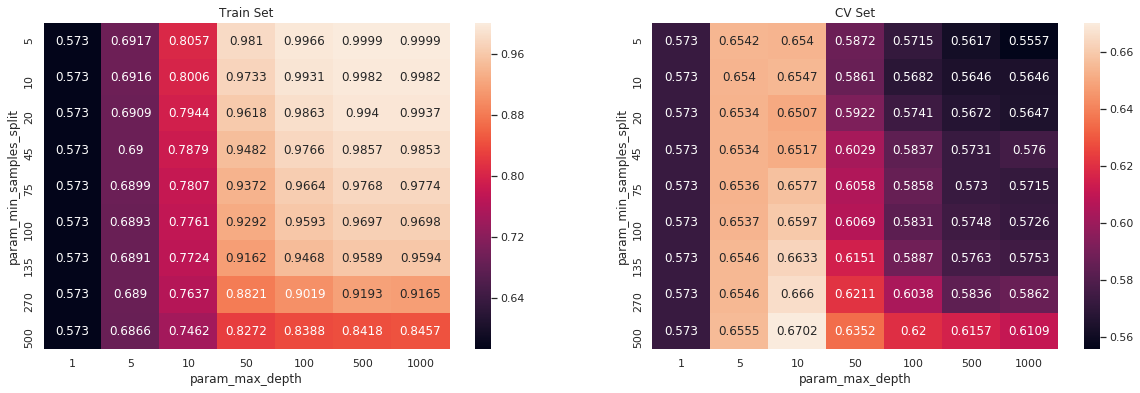

In [65]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf1.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

###  Best Estimator and Best tune parameters using the inbuilt parametrs (best_estimator_)

In [66]:
print(clf1.best_estimator_)
print("Using the best parametrs predict the best score for Test", clf1.score(X_set1_train,y_train))
print("Using the best parametrs predict the best score for Test",clf1.score(X_set1_test,y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Using the best parametrs predict the best score for Test 0.7417057565495966
Using the best parametrs predict the best score for Test 0.6621638401427135


### Training the Model with the best hyperparameter 

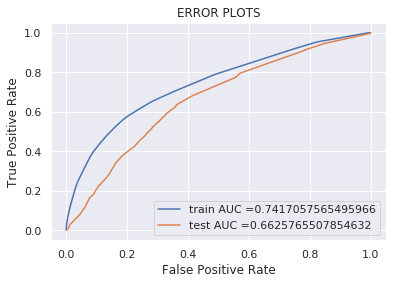

In [67]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clfV1=DecisionTreeClassifier(class_weight = 'balanced',max_depth=10,min_samples_split=500)
clfV1.fit(X_set1_train, y_train)
y_train_pred1 = clfV1.predict_proba(X_set1_train) [:,1]
y_test_pred1 = clfV1.predict_proba(X_set1_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [0]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions1 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.47 for threshold 0.41
the maximum value of tpr*(1-fpr) 0.41 for threshold 0.53


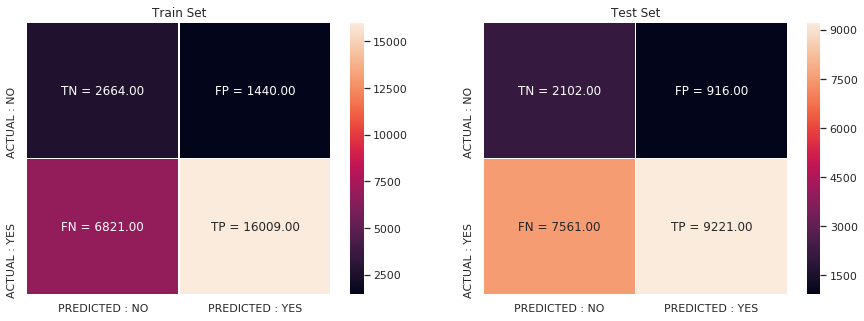

In [69]:
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)
sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()


### Getting all the Features of the Vectorizers as we have to use it to get the feature names in the desicion tree 

In [0]:
#Feature aggregation
f1=vectorizer1.get_feature_names()
f2=vectorizer2.get_feature_names()
f3=vectorizer3.get_feature_names()
f4=vectorizer4.get_feature_names()
f5=vectorizer5.get_feature_names()
fb=vectorizer6.get_feature_names()
ft=vectorizer7.get_feature_names()
fb1=vectorizer8.get_feature_names()
ft1=vectorizer9.get_feature_names()

feature_agg_bow = f1 + f2 + f3 + f4 + f5 + fb + ft
feature_agg_tfidf = f1 + f2 + f3 + f4 + f5 + fb1 + ft1
# p is price, q is quantity, t is teacher previous year projects
feature_agg_bow.append('price')
feature_agg_tfidf.append('price')
feature_agg_bow.append('quantity')
feature_agg_tfidf.append('quantity')
feature_agg_bow.append('teacher_previous_projects')
feature_agg_tfidf.append('teacher_previous_projects')

#### this model is created just to visualize the tree 

In [71]:
# this model is created just to visualize the tree 
clfVisual=DecisionTreeClassifier(class_weight = 'balanced',max_depth=3,min_samples_split=500)
clfVisual.fit(X_set1_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

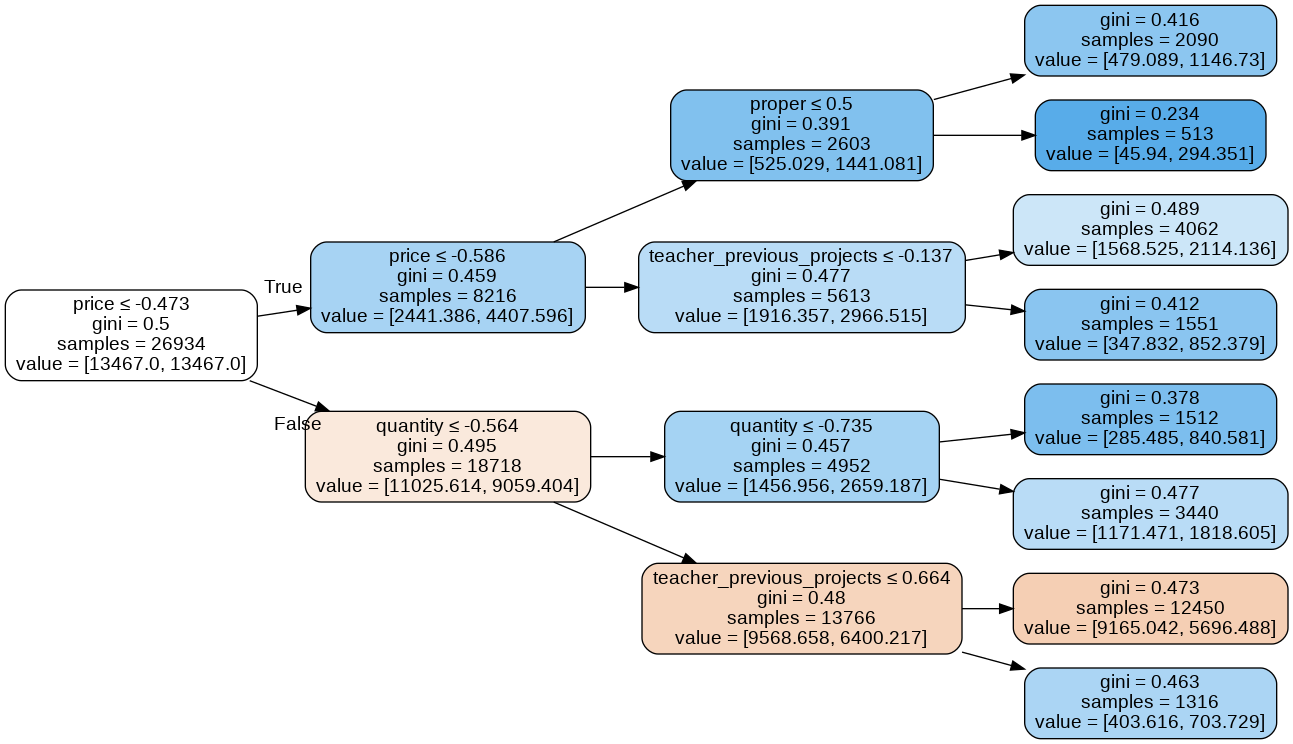

In [72]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
# the code implimented here can be found in the SKlearn Documentation 
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clfVisual, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_agg_bow,rotate=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


## Analysis on the False positives of the data 


1.   Fasle positive are those data points that are Wronlgy classified.



In [0]:
# The code for this taken as refrence from the links given below . 
#https://www.google.com/search?q=geeks+for+geeks+false+positive&rlz=1C1SQJL_enIN849IN849&oq=geeks+for+geeks+false+positive&aqs=chrome..69i57j33l5.6431j0j7&sourceid=chrome&ie=UTF-8
#https://github.com/pskadasi/DecisionTrees_DonorsChoose/blob/master/Copy_of_8_DonorsChoose_DT_(1).ipynb
fpi = []
for i in range(len(y_test)):
  if (y_test.values[i] == 0) & (predictions1[i] == 1) :
    fpi.append(i)
fp_essay1 = []
for i in fpi :
  fp_essay1.append(X_test['essay'].values[i])

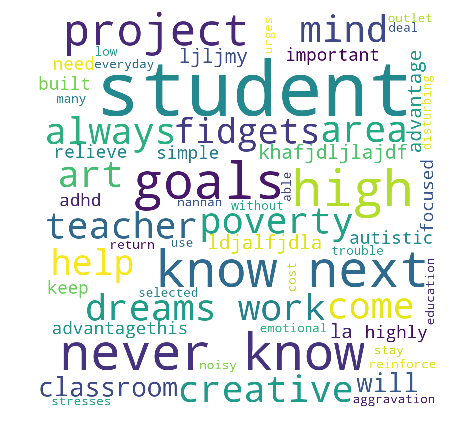

In [74]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1 :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [75]:
# create the DataFrame for Fasle Postive 
# https://www.geeksforgeeks.org/python-pandas-dataframe-filter
cols = X_test.columns
X_test_falsePos1 = pd.DataFrame(columns=cols)
for i in fpi : 
  X_test_falsePos1 = X_test_falsePos1.append(X_test.filter(items=[i], axis=0))

  
print(X_test_falsePos1.head(10))
print(len(X_test_falsePos1))

    Unnamed: 0       id  ...    price quantity
22      131770  p122192  ...   218.65       49
39       22359  p143812  ...    42.89       12
50      154539  p199520  ...   119.98        4
51       53873  p049872  ...  1434.54        5
65      111845  p078724  ...   392.99        4
68       60150  p038578  ...   191.98        4
74       35604  p015104  ...   309.14        2
90      167709  p020661  ...   279.99        1
125      40672  p125763  ...    93.14       27
140       9454  p043906  ...   277.02        1

[10 rows x 19 columns]
916


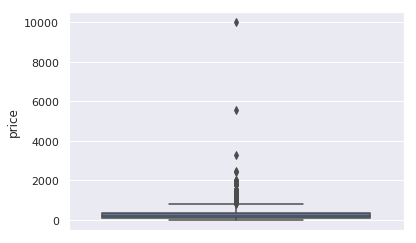

In [76]:
# https://seaborn.pydata.org/generated/seaborn.boxplot.html
sns.boxplot(y='price', data=X_test_falsePos1)

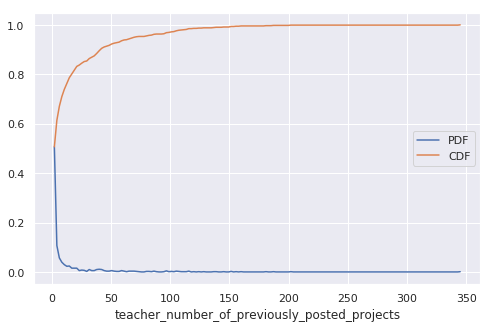

The plot above shows that the projects submetted by the teachers are low and very few have projects with high submission rate 


In [77]:
##PDF (FP ,teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos1['teacher_number_of_previously_posted_projects'],
bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()
print("The plot above shows that the projects submetted by the teachers are low and very few have projects with high submission rate ")

### Applying Decision trees on TFIDF Vectorization

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt2 = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
clf2 = GridSearchCV(dt2, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se2 = clf2.fit(X_set2_train, y_train)

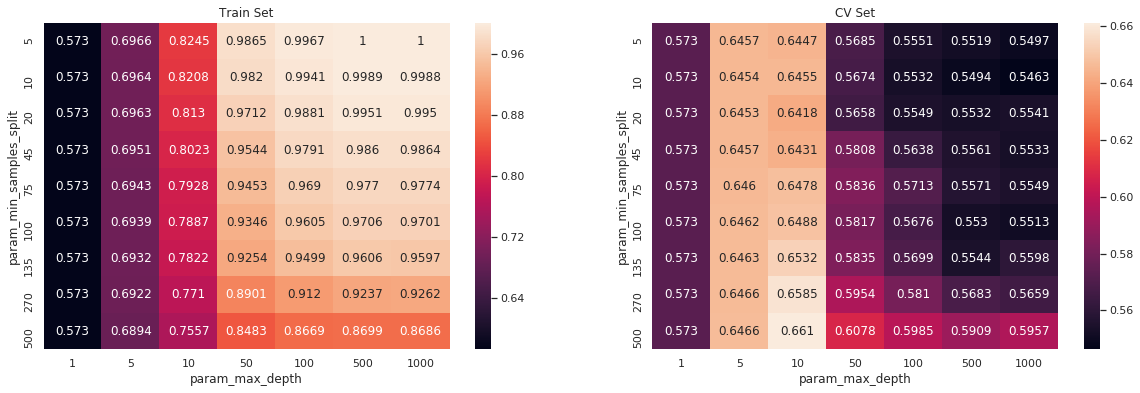

In [79]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf2.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [80]:
print(clf2.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf2.score(X_set2_train,y_train))
print(clf2.score(X_set2_test,y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.7574508038480882
0.6655654204909974


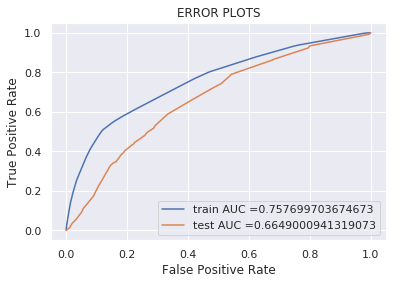

In [81]:
clfV1=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)
clfV1.fit(X_set2_train, y_train)
y_train_pred1 = clfV1.predict_proba(X_set2_train)[:,1]
y_test_pred1 = clfV1.predict_proba(X_set2_test)[:,1]

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.47 for threshold 0.44
the maximum value of tpr*(1-fpr) 0.39 for threshold 0.45


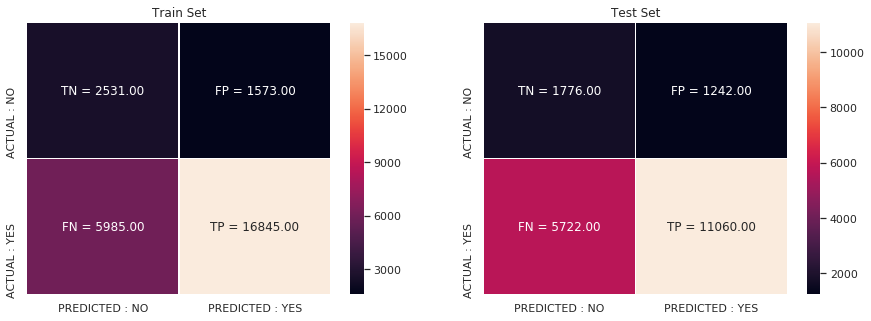

In [82]:
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
con_m_test.flatten())])).reshape(2,2)
sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()


In [83]:
# Model for visulaization of the graph 
clfV1=DecisionTreeClassifier (class_weight = 'balanced',max_depth=3,min_samples_split=500)
clfV1.fit(X_set2_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

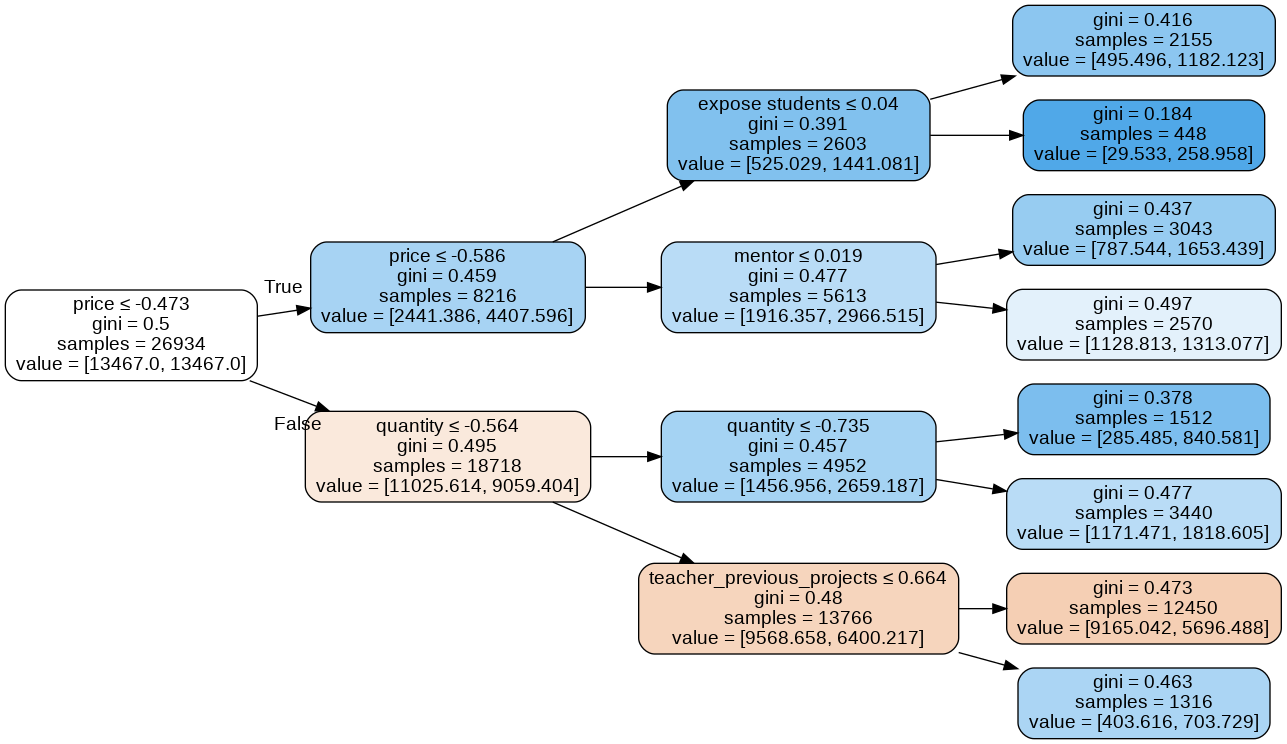

In [84]:
dot_data = StringIO()
export_graphviz(clfV1, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_agg_bow,rotate=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

#### Annalysis of the false positive rate 

In [0]:
fpi = []
for i in range(len(y_test)) :
  if (y_test.values[i] == 0) & (predictions1[i] == 1) :
    fpi.append(i)
fp_essay1 = []
for i in fpi :
  fp_essay1.append(X_test['essay'].values[i])

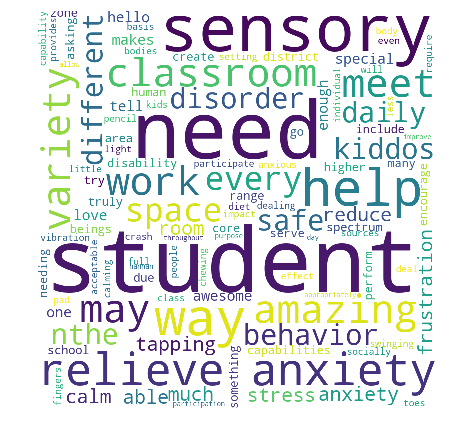

In [86]:
# Word cloud of essay
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1 :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [0]:
# Here we are appedning all the data points to a data frame that belong to Fasle Postive rate 
cols = X_test.columns
X_test_falsePos1 = pd.DataFrame(columns=cols)
for i in fpi:
  X_test_falsePos1 = X_test_falsePos1.append(X_test.filter(items=[i], axis=0))

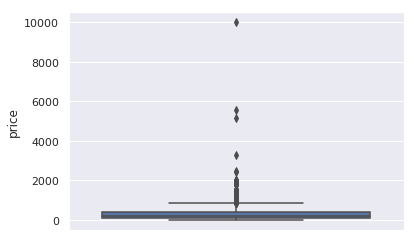

In [88]:
sns.boxplot(y='price', data=X_test_falsePos1)

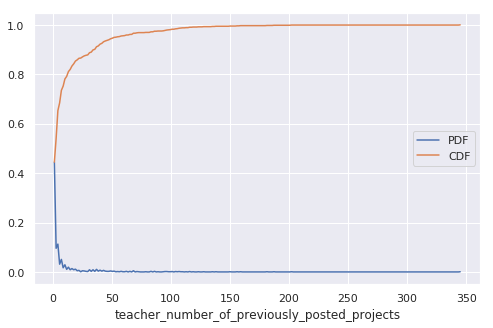

In [89]:
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos1['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

### Applying Decision trees on AVG W2V VEctorization

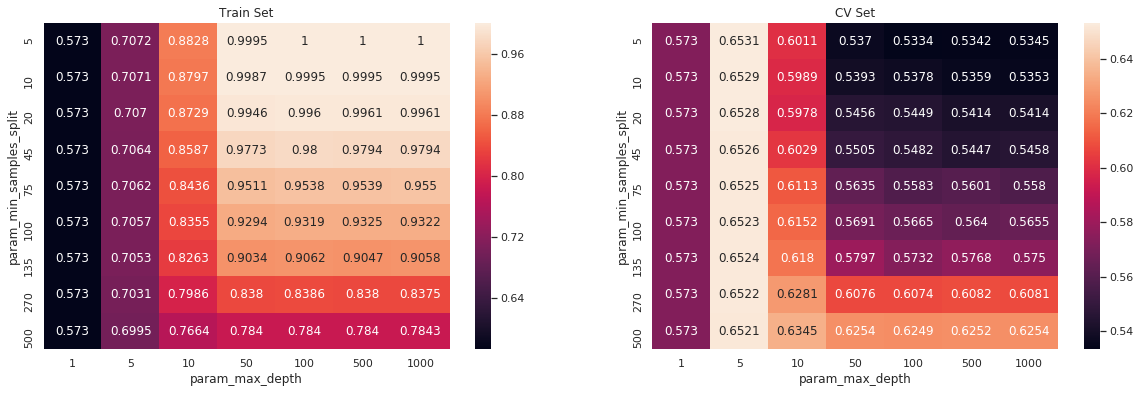

In [90]:
dt3= DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
clf3 = GridSearchCV(dt3, parameters, cv=3, scoring='roc_auc',n_jobs=4,return_train_score=True)
se3 = clf3.fit(X_set3_train, y_train)

import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf3.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [91]:
print(clf3.best_estimator_)
print(clf3.score(X_set3_train,y_train))
print(clf3.score(X_set3_test,y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.6997256930836361
0.6405664846972667


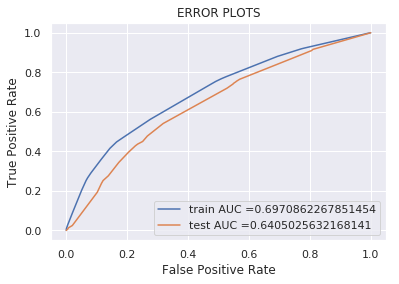

In [92]:
clfV1=DecisionTreeClassifier (class_weight = 'balanced',max_depth=5,min_samples_split=500)
clfV1.fit(X_set3_train, y_train)
y_train_pred1 = clfV1.predict_proba(X_set3_train) [:,1]
y_test_pred1 = clfV1.predict_proba(X_set3_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.41 for threshold 0.47
the maximum value of tpr*(1-fpr) 0.37 for threshold 0.47


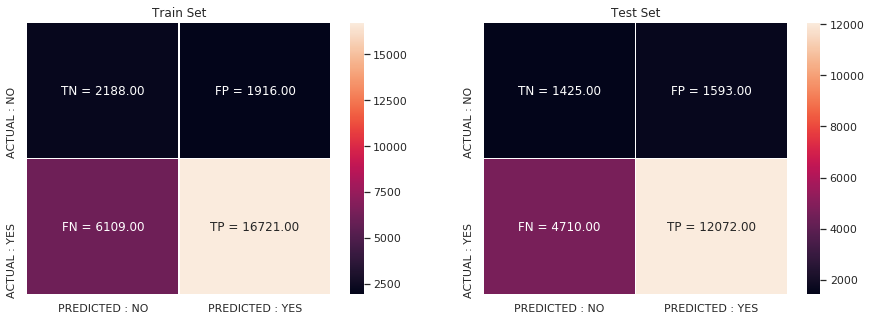

In [93]:
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)
sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],
yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],
yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

In [0]:
fpi = []
for i in range(len(y_test)) :
  if (y_test.values[i] == 0) & (predictions1[i] == 1) :
    fpi.append(i)
fp_essay1 = []
for i in fpi :
  fp_essay1.append(X_test['essay'].values[i])

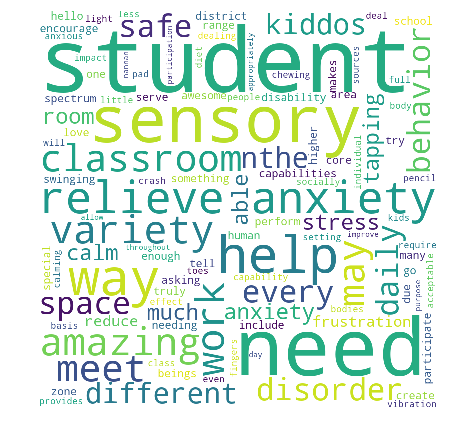

In [95]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1 :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [0]:
cols = X_test.columns
X_test_falsePos1 = pd.DataFrame(columns=cols)
for i in fpi : 
  X_test_falsePos1 = X_test_falsePos1.append(X_test.filter(items=[i], axis=0))


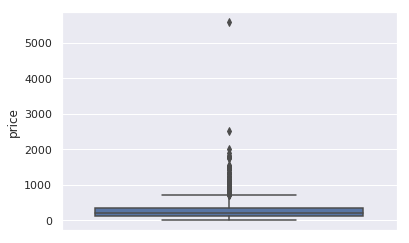

In [97]:
sns.boxplot(y='price', data=X_test_falsePos1)

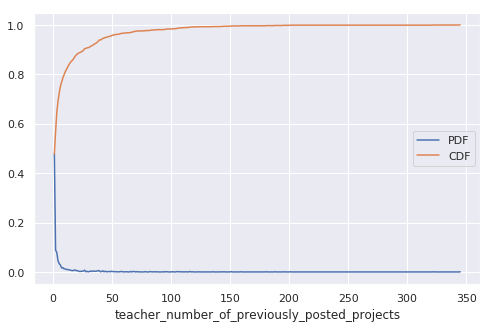

In [98]:
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos1['teacher_number_of_previously_posted_projects'],
bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

## Applying Decision trees on W2V weighted td_idf Vectorization 

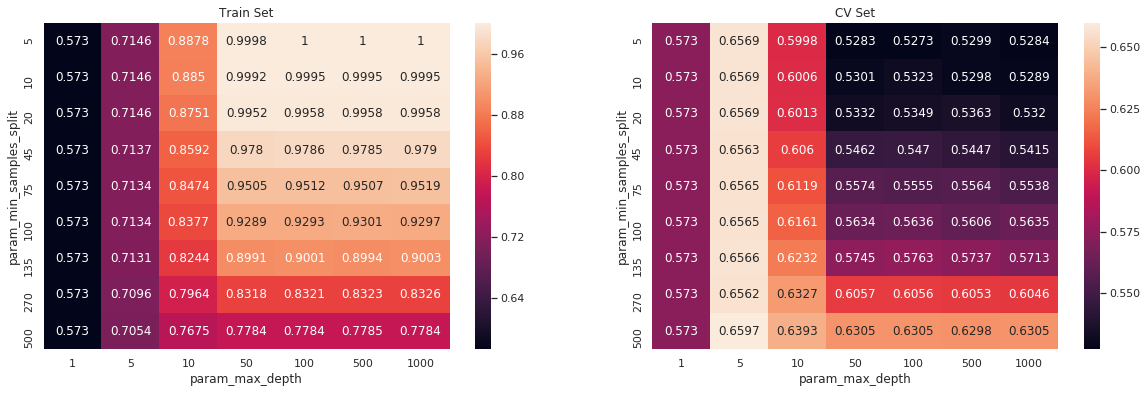

In [99]:
dt4= DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
clf4 = GridSearchCV(dt4, parameters, cv=3, scoring='roc_auc',return_train_score=True)
set4= clf4.fit(X_set4_train, y_train)

import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf4.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [100]:
#Best Estimator and Best tune parameters
print(clf4.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf4.score(X_set4_train,y_train))
print(clf4.score(X_set4_test,y_test))


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.7036435346347569
0.6119030464256925


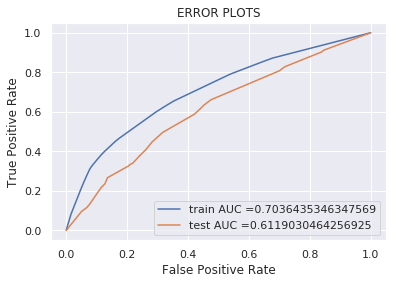

In [101]:
clfV1=DecisionTreeClassifier (class_weight = 'balanced',max_depth=5,min_samples_split=500)
clfV1.fit(X_set4_train, y_train)
y_train_pred1 = clfV1.predict_proba(X_set4_train)[:,1]
y_test_pred1 = clfV1.predict_proba(X_set4_test)[:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.42 for threshold 0.48
the maximum value of tpr*(1-fpr) 0.35 for threshold 0.52


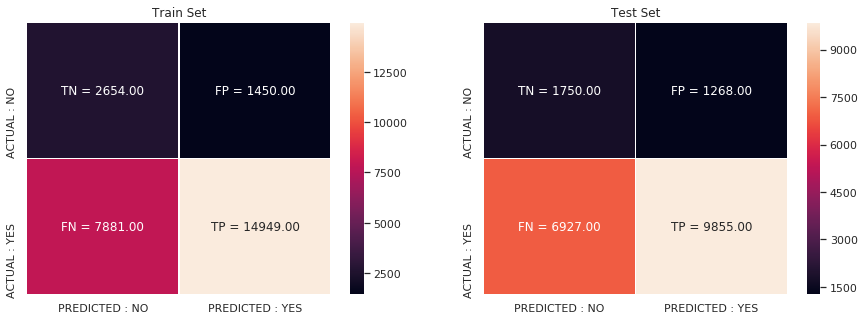

In [102]:
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)
sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

In [0]:
#Analysis on the False positives
fpi = []
for i in range(len(y_test)) :
  if (y_test.values[i] == 0) & (predictions1[i] == 1) :
    fpi.append(i)
fp_essay1 = []
for i in fpi :
  fp_essay1.append(X_test['essay'].values[i])

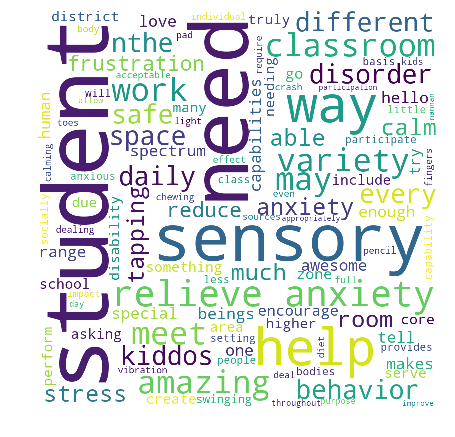

In [104]:
#WORD CLOUD OF ESSAY
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1 :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

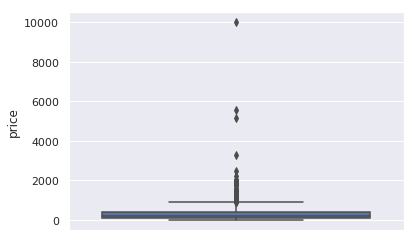

In [105]:
#Box Plot (FP 'price')
# first get the columns:
cols = X_test.columns
X_test_falsePos1 = pd.DataFrame(columns=cols)
# get the data of the false pisitives
for i in fpi : # (in fpi all the false positives data points indexes)
  X_test_falsePos1 = X_test_falsePos1.append(X_test.filter(items=[i], axis=0))
sns.boxplot(y='price', data=X_test_falsePos1)

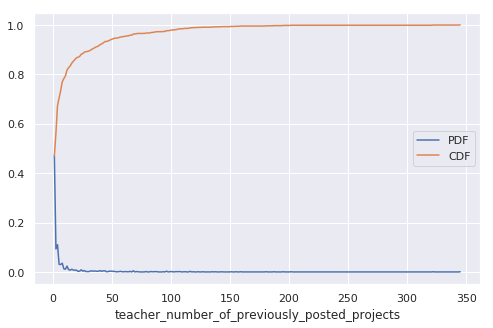

In [106]:
#PDF (FP ,teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos1['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

### Getting the 5000 most important features from the Data metrix of set- 2

the below refrence give very usefull information about the extraction of features.
1.   https://stackoverflow.com/questions/47111434/randomforestregressor-and-feature-importances-error
2.   https://stackoverflow.com/questions/48377296/get-feature-importance-from-gridsearchcv
3.   https://datascience.stackexchange.com/questions/31406/tree-decisiontree-feature-importances-numbers-correspond-to-how-features



In [0]:
def selectKFeatures(model, X, k=5):
    return X[:,model.best_estimator_.feature_importances_.argsort()[::-1][:k]]

In [108]:
X_set2_train=X_set2_train.tocsr()
X_set5_train = selectKFeatures(clf2, X_set2_train,5000)
X_set5_test = selectKFeatures(clf2, X_set2_test, 5000)

print(X_set5_train.shape)
print(X_set5_test.shape)

(26934, 5000)
(19800, 5000)


## Applying Desision trees on the Important features selected .


1.   Not applying any general linear model as the data points are low 
2.   As the distance between the Auc-Roc curve between the train and test are wider from here we know that it is a high Varience model .
3.   Desicion trees work well on high varince and low baise model. 



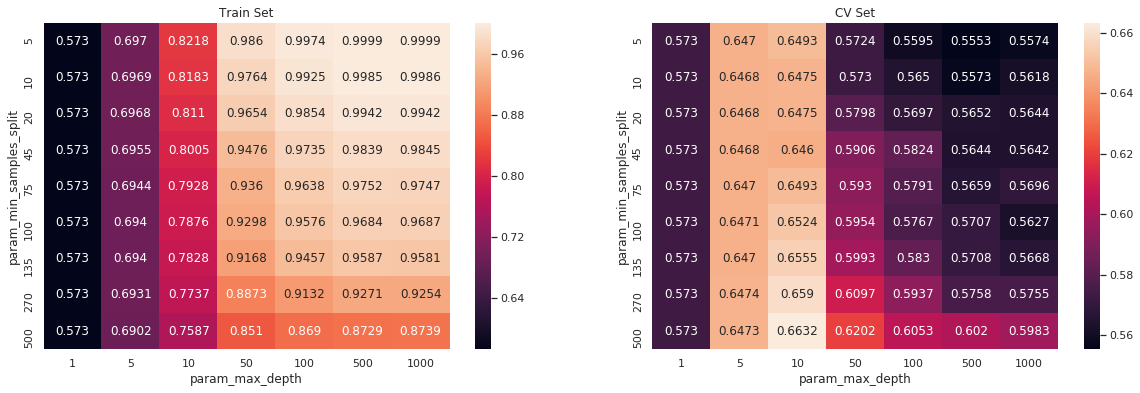

In [109]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt5= DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
clf5 = GridSearchCV(dt5, parameters, cv=3, scoring='roc_auc',return_train_score=True)
set5= clf5.fit(X_set5_train, y_train)


import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf5.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [110]:
#Best Estimator and Best tune parameters
print(clf5.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf5.score(X_set5_train,y_train))
print(clf5.score(X_set5_test,y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.7576592102915096
0.6650682051574871


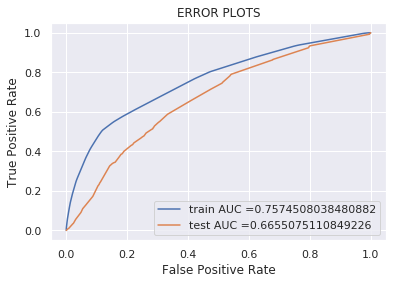

In [113]:
clfV1=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)
clfV1.fit(X_set5_train, y_train)
y_train_pred1 = clfV1.predict_proba(X_set5_train) [:,1]
y_test_pred1 = clfV1.predict_proba(X_set5_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.47 for threshold 0.44
the maximum value of tpr*(1-fpr) 0.39 for threshold 0.45


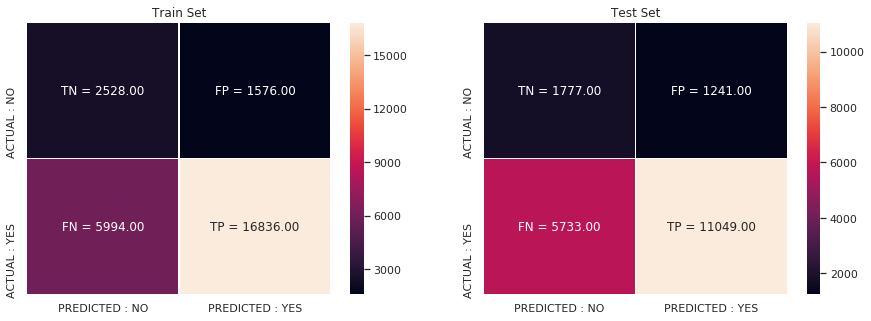

In [114]:
#CONFUSION MATRIX
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
con_m_test.flatten())])).reshape(2,2)
sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

In [0]:
#Analysis on the False positives

fpi = []
for i in range(len(y_test)) :
    if (y_test.values[i] == 0) & (predictions1[i] == 1) :
      fpi.append(i)
fp_essay1 = []
for i in fpi :
  fp_essay1.append(X_test['essay'].values[i])

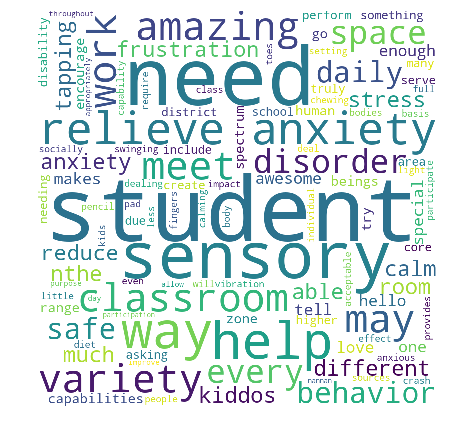

In [116]:
# Word cloud of essay
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1 :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

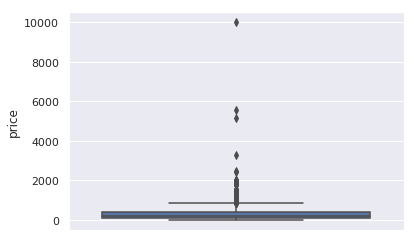

In [117]:
#Box Plot (FP 'price')
# first get the columns:
cols = X_test.columns
X_test_falsePos1 = pd.DataFrame(columns=cols)
# get the data of the false pisitives
for i in fpi : # (in fpi all the false positives data points indexes)
  X_test_falsePos1 = X_test_falsePos1.append(X_test.filter(items=[i], axis=0))
sns.boxplot(y='price', data=X_test_falsePos1)

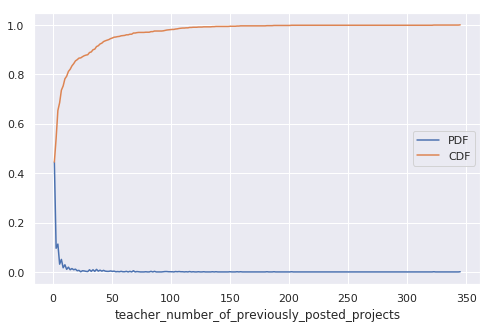

In [118]:
#PDF (FP ,teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos1['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

In [120]:
#how to use pretty table http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Vectorizer ", " Max_depth ", " Min_sample_split "," Test -AUC " , "Train - AUc")
tb.add_row([" BOW ", 10, 500, 67,74])
tb.add_row([" Tf - Idf", 10 , 500 ,66,75 ])
tb.add_row([" AVG-W2V", 5, 500,64,69])
tb.add_row(["A VG - Tf - Idf", 5 , 500 ,61,70])
tb.add_row(["Top 5000 Features", 10, 500 ,66,75 ])
print(tb.get_string(titles = "Decision trees- Observations")) 

+-------------------+-------------+--------------------+-------------+-------------+
|     Vectorizer    |  Max_depth  |  Min_sample_split  |  Test -AUC  | Train - AUc |
+-------------------+-------------+--------------------+-------------+-------------+
|        BOW        |      10     |        500         |      67     |      74     |
|      Tf - Idf     |      10     |        500         |      66     |      75     |
|       AVG-W2V     |      5      |        500         |      64     |      69     |
|  A VG - Tf - Idf  |      5      |        500         |      61     |      70     |
| Top 5000 Features |      10     |        500         |      66     |      75     |
+-------------------+-------------+--------------------+-------------+-------------+
